In [1]:
from math import pi, sin, cos

from siltsong.stars import blackbody
from siltsong.dust import mrn, thermal_emission, henyey_greenstein
from siltsong import cartesian_to_spherical, plot_density_powernorm, radiative_transfer

In [2]:
view_length = 1e16
distance_steps = 200
theta_steps = 360
phi_steps = 360
distance_substeps = 10
dr = view_length / 2 / distance_steps
ds = dr / distance_substeps
dphi = pi / phi_steps

resolution = 201
depth = 201
depth_substeps = 10
dw = view_length / depth
ds_depth = dw / depth_substeps
grid_size = view_length / resolution

inclination_degrees = 60
inclination = pi * (inclination_degrees / 180)
sin_inc = sin(inclination)
cos_inc = cos(inclination)

ms_count = 100

wavelength = 5.47e-5

grain_size_min = 5e-7
grain_size_max = 1e-4
exponent = -3.5
rho_gr = 3
sigma_rho_gr = 1.109

In [3]:
central_source = blackbody(wavelength, temperature = 20000)
    
sca_cm_squared_per_g, ext_cm_squared_per_g = mrn(grain_size_min, grain_size_max, exponent, rho_gr, sigma_rho_gr, wavelength)

sca_cm_squared_per_g, ext_cm_squared_per_g = mrn() # Alternatively use default parameters, identical to above

source_function = thermal_emission(wavelength, temperature = 10)

def scattering_phase_function(angle):
    return henyey_greenstein(angle, asymmetry_constant = 0.6)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/siltsong/dust.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scattering_efficiency_integral = quad(lambda a: a ** (2 + exponent) * Q_sca_lambda(2 * pi * a / wavelength), grain_size_min, grain_size_max)[0] # integral after P in formual A8 of Li et al. 2024
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/siltsong/dust.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to 

In [4]:
def density_spherical(r, theta):
    if r <= 2e14 or r > 4e15:
        return 0
    return 10 / r ** 2

def density_cartesian(x, y, z):
    r, theta, _ = cartesian_to_spherical(x, y, z)
    return density_spherical(r, theta)

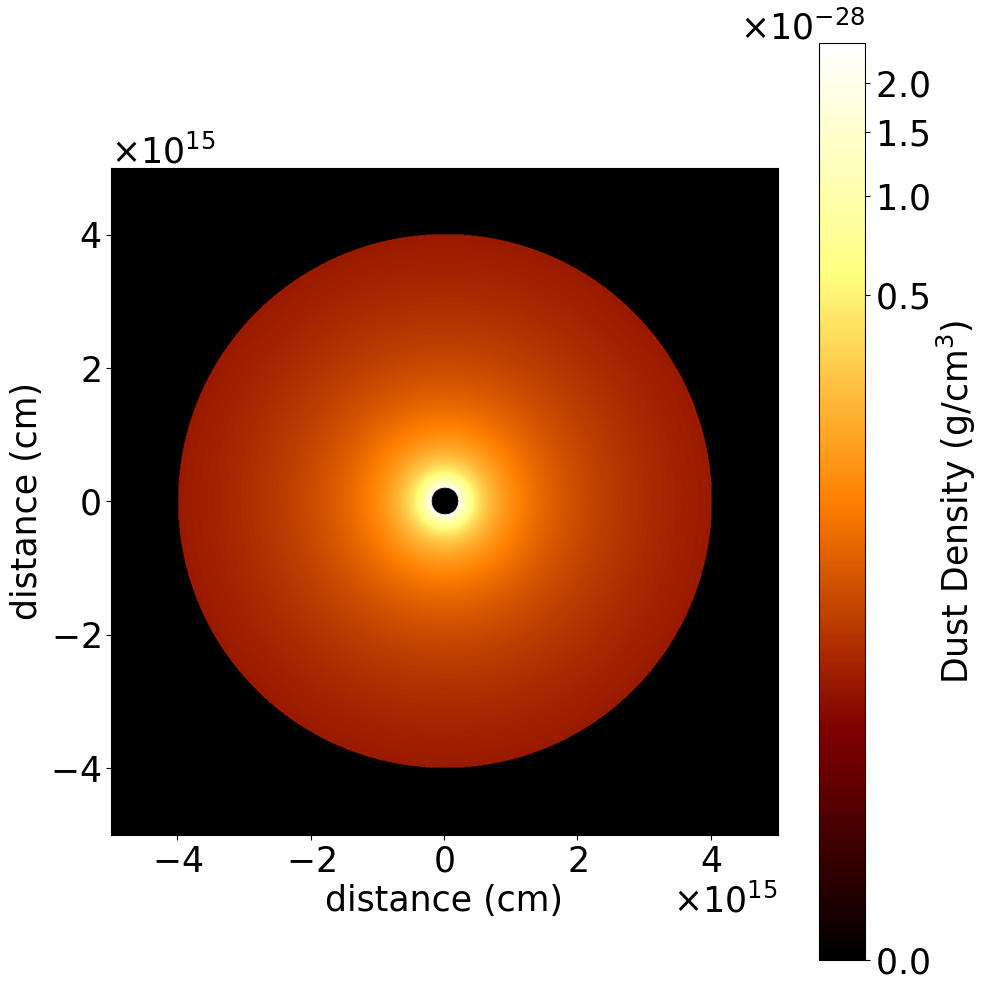

In [5]:
plot_density_powernorm(density_cartesian, view_length, power = 0.2)

In [6]:
image = radiative_transfer(view_length, inclination_degrees, resolution, 
                           central_source, 
                           density_spherical, density_cartesian, 
                           sca_cm_squared_per_g, ext_cm_squared_per_g, source_function, scattering_phase_function, 
                           depth, depth_substeps, distance_steps, distance_substeps, theta_steps, phi_steps, 
                           ms_count)

Sending isotropic photons from central star(s): 


100%|█████████████████████████████████████████| 360/360 [01:04<00:00,  5.62it/s]


Tracing multiple scattered photons: 


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1953.73it/s]


Performing peel-off: 


100%|█████████████████████████████████████████| 201/201 [00:19<00:00, 10.42it/s]


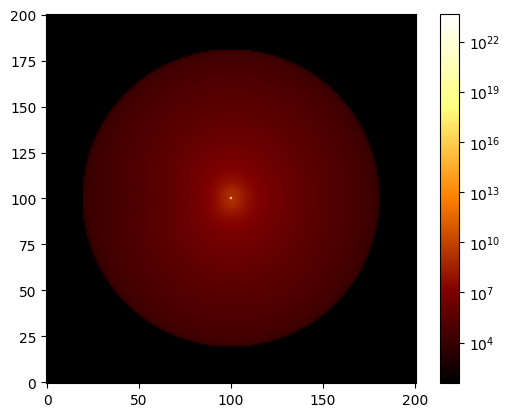

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

buffer = np.min(image[image > 0])
buffered_image = image.copy()
buffered_image[buffered_image <= buffer] = buffer

plt.imshow(buffered_image, origin = 'lower', cmap = 'afmhot', norm = LogNorm())
plt.colorbar()
plt.show()

In [9]:
# END